In [118]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splprep, splev
import turtle
import tensorflow as tf
from tensorflow import keras
import random
import sys
import json
import math
import matplotlib.pyplot as plt
import numpy as np

import pso

from shapely.geometry import LineString
from utils import plot_lines, get_closet_points

In [120]:
# A basic GUI using openCV which will give us the desired control points to generate a Spline (out racing track)


def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        x_arr.append(y)
        y_arr.append(x)
        for i in range(x - 5, x + 5):
            for j in range(y - 5, y + 5):
                img[j, i] = (255, 255, 255)

        cv2.imshow("image", img)


if __name__ == "__main__":
    x_arr = []
    y_arr = []
    img = cv2.imread("imgg.jpg", 1)

    cv2.imshow("image", img)

    cv2.setMouseCallback("image", click_event)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # arr.append(arr[0])
    x_arr.append(x_arr[0])
    y_arr.append(y_arr[0])

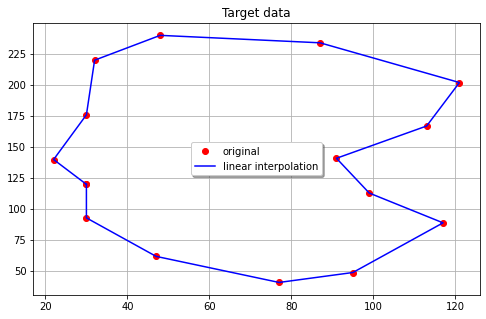

In [121]:
# Let us plot the map

plt.plot(x_arr, y_arr, "ro", label="original")
plt.plot(x_arr, y_arr, "b", label="linear interpolation")
plt.title("Target data")
plt.legend(loc="best", fancybox=True, shadow=True)
plt.grid()

In [122]:
# Let us use these points as control points for generating a spline through it


def generate_spline_interpolation(x_arr, y_arr, num_points=100, smoothing=0):
    tck, u = splprep([x_arr, y_arr], s=smoothing, per=1)
    new_points = splev(np.linspace(0, 1, num_points), tck, der=0)
    return new_points


data = generate_spline_interpolation(x_arr, y_arr)
data[0] = data[0].astype(int)
data[1] = data[1].astype(int)

result = [[x, y] for x, y in zip(data[0], data[1])]
print(result)

[[30, 120], [30, 114], [30, 109], [30, 104], [29, 99], [29, 94], [30, 89], [31, 84], [33, 80], [36, 75], [39, 71], [42, 67], [46, 62], [50, 58], [54, 54], [58, 50], [62, 46], [66, 43], [71, 41], [75, 41], [80, 41], [84, 42], [89, 45], [94, 48], [98, 52], [103, 56], [107, 60], [110, 65], [113, 70], [115, 74], [117, 79], [117, 84], [117, 88], [115, 92], [112, 96], [109, 100], [105, 104], [102, 109], [98, 113], [95, 118], [93, 123], [91, 128], [90, 133], [90, 138], [91, 142], [93, 146], [97, 150], [100, 154], [104, 158], [108, 161], [112, 166], [115, 170], [118, 175], [120, 180], [121, 185], [122, 190], [122, 196], [121, 200], [119, 205], [117, 209], [114, 213], [111, 217], [107, 221], [103, 224], [98, 227], [93, 230], [88, 233], [83, 235], [78, 237], [72, 239], [67, 241], [62, 242], [57, 242], [52, 241], [48, 240], [43, 237], [40, 233], [36, 229], [34, 225], [32, 220], [30, 215], [30, 210], [30, 204], [30, 199], [30, 194], [30, 189], [30, 184], [30, 179], [29, 173], [28, 168], [26, 163],

# PSO

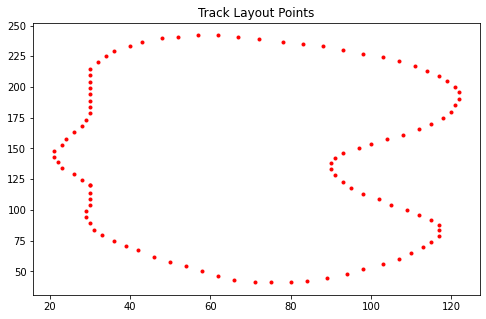

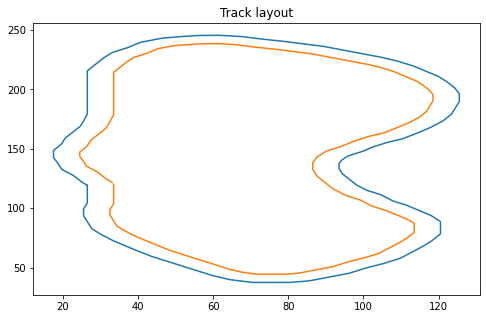

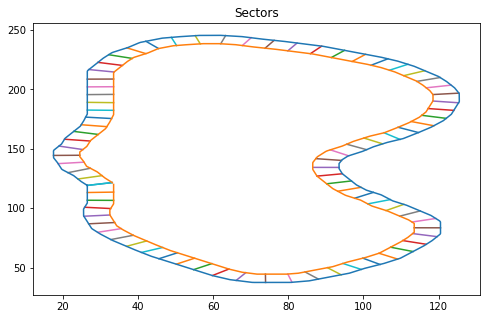

Population initialization...
Optimizing


KeyboardInterrupt: 

In [123]:
def main():
    # PARAMETERS
    N_SECTORS = 80
    N_PARTICLES = 100
    N_ITERATIONS = 400
    W = -0.3256
    CP = -0.1664
    CG = 3.9876
    PLOT = True



    track_layout = result
    track_width = 7

    # Compute inner and outer tracks borders
    center_line = LineString(track_layout)
    inside_line = LineString(center_line.parallel_offset(track_width / 2, "left"))
    outside_line = LineString(center_line.parallel_offset(track_width / 2, "right"))

    if PLOT:
        plt.title("Track Layout Points")
        for p in track_layout:
            plt.plot(p[0], p[1], "r.")
        plt.show()
        plt.title("Track layout")
        plot_lines([outside_line, inside_line])
        plt.show()

    # Define sectors' extreme points (in coordinates). Each sector segment is defined by an inside point and an outside point.
    inside_points, outside_points = define_sectors(
        center_line, inside_line, outside_line, N_SECTORS
    )

    if PLOT:
        plt.title("Sectors")
        for i in range(N_SECTORS):
            plt.plot(
                [inside_points[i][0], outside_points[i][0]],
                [inside_points[i][1], outside_points[i][1]],
            )
        plot_lines([outside_line, inside_line])
        plt.show()

    # Define the boudaries that will be passed to the pso algorithm [0 - trackwidth].
    # 0 correspond to the inner border, trackwidth to the outer border.
    boundaries = []
    for i in range(N_SECTORS):
        boundaries.append(np.linalg.norm(inside_points[i] - outside_points[i]))

    def myCostFunc(sectors):
        return get_lap_time(
            sectors_to_racing_line(sectors, inside_points, outside_points)
        )

    global_solution, gs_eval, gs_history, gs_eval_history = pso.optimize(
        cost_func=myCostFunc,
        n_dimensions=N_SECTORS,
        boundaries=boundaries,
        n_particles=N_PARTICLES,
        n_iterations=N_ITERATIONS,
        w=W,
        cp=CP,
        cg=CG,
        verbose=True,
    )

    _, v, x, y = get_lap_time(
        sectors_to_racing_line(global_solution, inside_points, outside_points),
        return_all=True,
    )

    if PLOT:
        plt.title("Racing Line History")
        plt.ion()
        for i in range(0, len(np.array(gs_history)), int(N_ITERATIONS / 10)):
            lth, vh, xh, yh = get_lap_time(
                sectors_to_racing_line(gs_history[i], inside_points, outside_points),
                return_all=True,
            )
            # plt.scatter(xh, yh, marker=".", c=vh, cmap="RdYlGn")
            # plot_lines([outside_line, inside_line])
            # plt.draw()
            # plt.pause(0.00000001)
            # plt.clf()
        plt.ioff()

        plt.title("Optimized Racing line")
        rl = np.array(
            sectors_to_racing_line(global_solution, inside_points, outside_points)
        )
        plt.plot(rl[:, 0], rl[:, 1], "r")
        plt.scatter(x, y, marker=".", c=v, cmap="RdYlGn")
        for i in range(N_SECTORS):
            plt.plot(
                [inside_points[i][0], outside_points[i][0]],
                [inside_points[i][1], outside_points[i][1]],
            )
        plot_lines([outside_line, inside_line])
        plt.show()

        plt.title("Cost History")
        plt.ylabel("lap_time (s)")
        plt.xlabel("n_iteration")
        plt.plot(gs_eval_history)
        plt.show()


def sectors_to_racing_line(sectors: list, inside_points: list, outside_points: list):
    """Sectors to racing line coordinate
    """

    racing_line = []
    for i in range(len(sectors)):
        x1, y1 = inside_points[i][0], inside_points[i][1]
        x2, y2 = outside_points[i][0], outside_points[i][1]
        m = (y2 - y1) / (x2 - x1)

        a = math.cos(math.atan(m))  # angle with x axis
        b = math.sin(math.atan(m))  # angle with x axis

        xp = x1 - sectors[i] * a
        yp = y1 - sectors[i] * b

        if (
            abs(math.dist(inside_points[i], [xp, yp]))
            + abs(math.dist(outside_points[i], [xp, yp]))
            - abs(math.dist(outside_points[i], inside_points[i]))
            > 0.1
        ):
            xp = x1 + sectors[i] * a
            yp = y1 + sectors[i] * b

        racing_line.append([xp, yp])
    return racing_line


def get_lap_time(racing_line: list, return_all=False):
    """Fitness function
    """
    # Computing the spline function passing throught the racing_line points
    rl = np.array(racing_line)
    tck, _ = interpolate.splprep([rl[:, 0], rl[:, 1]], s=0.0, per=0)
    x, y = interpolate.splev(np.linspace(0, 1, 1000), tck)

    # Computing derivatives
    dx, dy = np.gradient(x), np.gradient(y)
    d2x, d2y = np.gradient(dx), np.gradient(dy)

    curvature = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy) ** 1.5
    radius = [1 / c for c in curvature]

    us = 0.13  # Coefficient of friction

    # Computing speed at each point
    v = [min(10, math.sqrt(us * r * 9.81)) for r in radius]

    # Computing lap time around the track
    lap_time = sum(
        [
            math.sqrt((x[i] - x[i + 1]) ** 2 + (y[i] - y[i + 1]) ** 2) / v[i]
            for i in range(len(x) - 1)
        ]
    )

    if return_all:
        return lap_time, v, x, y
    return lap_time


def define_sectors(
    center_line: LineString,
    inside_line: LineString,
    outside_line: LineString,
    n_sectors: int,
):
    
    distances = np.linspace(0, center_line.length, n_sectors)
    center_points_temp = [center_line.interpolate(distance) for distance in distances]
    center_points = np.array(
        [
            [center_points_temp[i].x, center_points_temp[i].y]
            for i in range(len(center_points_temp) - 1)
        ]
    )
    center_points = np.append(center_points, [center_points[0]], axis=0)

    distances = np.linspace(0, inside_line.length, 1000)
    inside_border = [inside_line.interpolate(distance) for distance in distances]
    inside_border = np.array([[e.x, e.y] for e in inside_border])
    inside_points = np.array(
        [
            get_closet_points([center_points[i][0], center_points[i][1]], inside_border)
            for i in range(len(center_points))
        ]
    )

    distances = np.linspace(0, outside_line.length, 1000)
    outside_border = [outside_line.interpolate(distance) for distance in distances]
    outside_border = np.array([[e.x, e.y] for e in outside_border])
    outside_points = np.array(
        [
            get_closet_points(
                [center_points[i][0], center_points[i][1]], outside_border
            )
            for i in range(len(center_points))
        ]
    )

    return inside_points, outside_points


if __name__ == "__main__":
    main()

# Genetic Algorithm

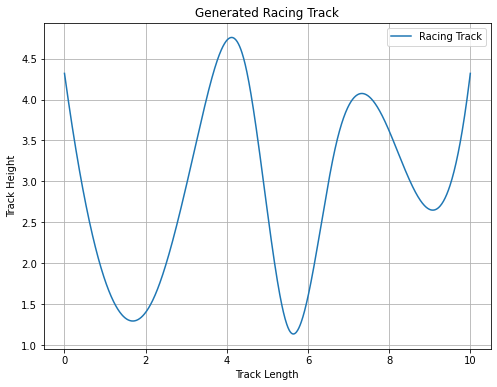

KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import differential_evolution


# Function to generate a racing track using splines
def generate_racing_track(num_points=10):
    # Generate random control points for the spline
    x = np.linspace(0, 10, num_points)
    y = np.random.uniform(0, 5, num_points)

    # Ensure periodic condition
    y[-1] = y[0]

    # Create a cubic spline
    cs = CubicSpline(x, y)

    track_points = np.linspace(0, 10, 1000)
    track = cs(track_points)

    return track_points, track


# Objective function to minimize (negative of the track height at each point)
def objective_function(x, track_points):
    # Ensure periodic condition
    x[-1] = x[0]

    # Create a cubic spline without periodic conditions
    cs = CubicSpline(track_points, x)

    return -np.mean(cs(track_points))


# Genetic Algorithm parameters
POP_SIZE = 100
NGEN = 50

# Generate racing track
track_points, track = generate_racing_track()

# Plot the racing track
plt.figure(figsize=(8, 6))
plt.plot(track_points, track, label="Racing Track")
plt.title("Generated Racing Track")
plt.xlabel("Track Length")
plt.ylabel("Track Height")
plt.legend()
plt.grid(True)
plt.show()

# Differential Evolution algorithm
results = differential_evolution(
    objective_function,
    bounds=[(0, 5)] * len(track_points),
    args=(track_points,),
    popsize=POP_SIZE,
    maxiter=NGEN,
    tol=1e-3,
)

# Extract the optimized racing line
optimized_racing_line = results.x

# Plot the optimized racing line
plt.figure(figsize=(8, 6))
plt.plot(track_points, track, label="Racing Track")
plt.plot(
    track_points,
    optimized_racing_line,
    label="Optimized Racing Line",
    linestyle="--",
    linewidth=2,
)
plt.title("Optimized Racing Line on the Track using Differential Evolution")
plt.xlabel("Track Length")
plt.ylabel("Track Height")
plt.legend()
plt.grid(True)
plt.show()

# Iterative optimization

In [91]:
import pygame, sys
import math
import random as rn
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline
plt.rcParams.update({'figure.figsize': [8,5]})

sys.path.append('procedural_tracks/')
from procedural_tracks.main import *

np.set_printoptions(precision=3, suppress=True)

In [98]:
# helper functions


def get_track_points_from_random_track(seed=8, sample=20):
    rn.seed(seed)
    points = random_points()
    hull = ConvexHull(points)
    track_points_coarse = shape_track(get_track_points(hull, points))
    corner_points = get_corners_with_kerb(track_points_coarse)
    track_points = smooth_track(track_points_coarse)[::sample]
    
    return track_points


def racing_line_length(points):
    x, y = zip(*points)
    num_points = len(points)
    length = np.sum(
        [
            np.sqrt((x[i] - x[i + 1]) ** 2 + (y[i] - y[i + 1]) ** 2)
            for i in range(num_points - 1)
        ]
    )
    return length


# this is slightly incorrect, the new point can be (max_offset, max_offset) away
# use a 2d gaussian instead?
def get_new_point(old_point, baseline, spread, max_offset_from_baseline):
    old_x, old_y = old_point
    baseline_x, baseline_y = baseline
    while True:
        potential_x = old_x + (np.random.random() - 0.5) * spread
        if abs(potential_x - baseline_x) < max_offset_from_baseline:
            new_x = potential_x
            break
    while True:
        potential_y = old_y + (np.random.random() - 0.5) * spread
        if abs(potential_y - baseline_y) < max_offset_from_baseline:
            new_y = potential_y
            break
    return new_x, new_y

In [99]:
# cost functions


def racing_line_length_full(points_except_last, params={}):
    points = copy.deepcopy(points_except_last)
    points += [points[0]]
    x, y = zip(*points)
    num_points = len(points)
    length = np.sum(
        [
            np.sqrt((x[i] - x[i + 1]) ** 2 + (y[i] - y[i + 1]) ** 2)
            for i in range(num_points - 1)
        ]
    )
    return length


def _angle_between(vector1, vector2):
    vector1_unit = vector1 / np.linalg.norm(vector1)
    vector2_unit = vector2 / np.linalg.norm(vector2)
    angle = np.arccos(np.clip(np.dot(vector1_unit, vector2_unit), -1.0, 1.0))
    sign = np.sign(np.cross(vector1_unit, vector2_unit))
    return angle * sign


def sum_of_angles(points_except_last, params={}):
    num_points = len(points_except_last)
    points = copy.deepcopy(points_except_last)
    points += [points[0]]

    vectors = [
        (points[i + 1][0] - points[i][0], points[i + 1][1] - points[i][1])
        for i in range(num_points)
    ]
    vectors += [vectors[0]]
    angles = [
        abs_angle_between(vectors[i], vectors[i + 1]) for i in range(len(vectors) - 1)
    ]
    return np.std(angles), angles


def _length_and_angles(points_except_last):
    #     length = racing_line_length_full(points_except_last)
    #     angles = sum_of_angles(points_except_last)
    points = copy.deepcopy(points_except_last)
    points += [points[0]]
    x, y = zip(*points)
    num_points = len(points)
    vectors = [(x[i + 1] - x[i], y[i + 1] - y[i]) for i in range(num_points - 1)]
    vectors += [vectors[0]]

    length = np.sum(
        [
            np.sqrt(vectors[i][0] ** 2 + vectors[i][1] ** 2)
            for i in range(len(vectors) - 1)
        ]
    )
    angles = np.std(
        [_angle_between(vectors[i], vectors[i + 1]) for i in range(len(vectors) - 1)]
    )

    return (length, angles)


def length_and_angles(
    points_except_last, params={"reg_param": 0.0, "init_cost": (1.0, 1.0)}
):
    reg_param = params["reg_param"]
    init_cost = params["init_cost"]

    length, angles = _length_and_angles(points_except_last)
    length_init, angles_init = init_cost
    length_normalized = length / length_init
    angles_normalized = angles / angles_init

    cost = length_normalized + reg_param * angles_normalized
    return cost

In [100]:
x1 = [1, 0]
y1 = [-1, -1] / np.sqrt(2)
print(np.cross(x1, y1), np.arccos(np.dot(x1, y1)))
x2 = [1, 0]
y2 = [-1, -1] / np.sqrt(2)
print(np.cross(x2, y2), np.arccos(np.dot(x2, y2)))
print(_angle_between(x1, y1))
print(_angle_between(x2, y2))

-0.7071067811865475 2.356194490192345
-0.7071067811865475 2.356194490192345
-2.356194490192345
-2.356194490192345


In [101]:
# optimization functions


def opt_random_perturbation(
    track_midpoints,
    compute_cost=racing_line_length_full,
    spread=10,
    iterations=100,
    track_width=0.65,
    debug=False,
    debug_iter=1000,
):
    best_racing_line = []
    best_racing_line_cost = np.inf
    num_track_points = np.array(track_midpoints).shape[0]
    max_offset_from_baseline = track_width / 2
    racing_line = [0] * (num_track_points)

    for iteration in range(iterations):
        for i in range(num_track_points):
            new_x, new_y = get_new_point(
                track_midpoints[i], track_midpoints[i], spread, max_offset_from_baseline
            )
            racing_line[i] = (new_x, new_y)
        cost = compute_cost(racing_line)
        if cost < best_racing_line_cost:
            best_racing_line = copy.deepcopy(racing_line)
            best_racing_line_cost = cost
        if debug:
            if iteration % debug_iter == 0:
                print(f"Best hiterto: {best_racing_line_cost:.3f}")
    return best_racing_line, best_racing_line_cost


def opt_iterative_improvement(
    track_midpoints,
    compute_cost=racing_line_length_full,
    cost_func_params={},
    spread=10,
    iterations=100,
    track_width=0.65,
    debug=False,
    debug_iter=1000,
):
    num_track_points = np.array(track_midpoints).shape[0]
    racing_line_old = copy.deepcopy(track_midpoints)
    racing_line_new = copy.deepcopy(racing_line_old)
    max_offset_from_baseline = track_width / 2
    init_cost = compute_cost(racing_line_old)
    print(f"Started with: {init_cost}")
    min_cost_so_far = init_cost

    for iteration in range(iterations):
        min_cost_iter = min_cost_so_far
        point = (-1, (0, 0))
        for i in range(num_track_points):  # can randomly sample points here
            new_x, new_y = get_new_point(
                racing_line_old[i], track_midpoints[i], spread, max_offset_from_baseline
            )
            racing_line_new[i] = (new_x, new_y)
            cost = compute_cost(racing_line_new, cost_func_params)
            if cost < min_cost_iter:
                point = (i, (new_x, new_y))
                min_cost_iter = cost
            racing_line_new[i] = racing_line_old[i]
        if min_cost_iter < min_cost_so_far:
            racing_line_new[point[0]] = point[1]
            min_cost_so_far = min_cost_iter
        if debug:
            if iteration % debug_iter == 0:
                print(f"Smallest hiterto: {min_cost_so_far:.3f}")
                # print(np.array(racing_line_new))
        racing_line_old = copy.deepcopy(racing_line_new)

    print(f"\nEnded with: {compute_cost(racing_line_new)}\n")
    return racing_line_new

In [102]:
def draw_track_and_racing_line(
    track_points,
    racing_line,
    track_width,
    compute_cost=racing_line_length_full,
    xlims=None,
    ylims=None,
    smooth=False,
    smooth_points=1000,
):
    track_points_x, track_points_y = zip(*track_points)
    plt.scatter(
        track_points_x,
        track_points_y,
        s=1000 * track_width,
        color="black",
        facecolor="None",
    )
    if xlims != None:
        plt.xlim((-2, 300))
    if ylims != None:
        plt.ylim((-2, 300))
    #     print(compute_cost(racing_line))
    racing_line = copy.deepcopy(racing_line)
    racing_line += [racing_line[0]]
    x, y = zip(*racing_line)
    plt.plot(x, y, "or")
    if smooth:
        tck, u = interpolate.splprep([x, y], s=0, per=True)
        xi, yi = interpolate.splev(np.linspace(0, 1, smooth_points), tck)
        plt.plot(xi, yi, "-b")
    else:
        plt.plot(x, y, "-b")
    # print(f'Length of racing line: {racing_line_length(racing_line):.3f}')


def draw_complete_track(track_seed=8, racing_line=None):
    pygame.init()
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    background_color = GRASS_GREEN
    screen.fill(background_color)

    rn.seed(track_seed)  # 8 is a nice simple track
    points = random_points()
    hull = ConvexHull(points)
    track_points = shape_track(get_track_points(hull, points))
    corner_points = get_corners_with_kerb(track_points)
    f_points = smooth_track(track_points)
    # get complete corners from keypoints
    corners = get_full_corners(f_points, corner_points)
    # draw the actual track (road, kerbs, starting grid)
    draw_track(screen, GREY, f_points, corners)
    # draw racing line
    draw_lines_from_points(screen, BLUE, racing_line)
    # draw checkpoints
    checkpoints = get_checkpoints(f_points)

    pygame.display.set_caption(TITLE)
    while True:  # main loop
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                sys.exit()
        pygame.display.update()

[(742, 198), (748, 234), (743, 273), (731, 314), (711, 355), (687, 394), (659, 425), (628, 445), (597, 450), (565, 439), (532, 418), (496, 397), (458, 384), (417, 388), (379, 406), (350, 436), (338, 476), (334, 514), (309, 532), (267, 528), (224, 507), (197, 477), (185, 440), (184, 400), (188, 358), (191, 317), (189, 277), (175, 243), (146, 214), (115, 190), (101, 166), (110, 141), (137, 115), (177, 90), (225, 67), (274, 45), (321, 29), (364, 20), (401, 25), (431, 47), (452, 88), (471, 122), (498, 111), (533, 91), (569, 117), (594, 118), (617, 89), (652, 96), (691, 126), (724, 165)]
[(39, 206), (36, 200), (34, 193), (34, 186), (35, 178), (36, 170), (37, 161), (38, 153), (39, 144), (38, 135), (37, 126), (35, 117), (33, 109), (32, 101), (32, 93), (33, 87), (36, 81), (41, 76), (47, 72), (54, 69), (62, 66), (71, 63), (79, 60), (86, 57), (94, 55), (102, 53), (109, 53), (117, 54), (126, 56), (134, 60), (142, 65), (149, 71), (154, 77), (156, 83), (156, 88), (152, 93), (146, 98), (138, 101), (

ValueError: Invalid inputs.

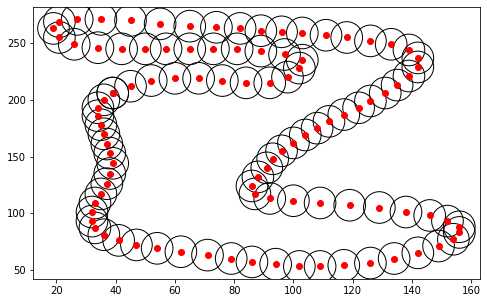

In [105]:
track_points = get_track_points_from_random_track(seed=95521, sample=20)
print(track_points)
ress = [(x, y) for x, y in result]
print(ress)
draw_track_and_racing_line(
    ress, ress, track_width=1, smooth=True, smooth_points=10
)
print(_length_and_angles(track_points))

# Iterative Improvement Algorithm - 1

Started with: 798.340991443102
Smallest hiterto: 2.001


C:\Users\priya\AppData\Local\Temp\ipykernel_23940\951336948.py:20: RuntimeWarning: invalid value encountered in true_divide
  vector2_unit = vector2 / np.linalg.norm(vector2)
C:\Users\priya\AppData\Local\Temp\ipykernel_23940\951336948.py:19: RuntimeWarning: invalid value encountered in true_divide
  vector1_unit = vector1 / np.linalg.norm(vector1)


Smallest hiterto: 1.978
Smallest hiterto: 1.962
Smallest hiterto: 1.940
Smallest hiterto: 1.928
Smallest hiterto: 1.916
Smallest hiterto: 1.909
Smallest hiterto: 1.892
Smallest hiterto: 1.873
Smallest hiterto: 1.872
Smallest hiterto: 1.871
Smallest hiterto: 1.863
Smallest hiterto: 1.857
Smallest hiterto: 1.857
Smallest hiterto: 1.855
Smallest hiterto: 1.853
Smallest hiterto: 1.849
Smallest hiterto: 1.845
Smallest hiterto: 1.843
Smallest hiterto: 1.835

Ended with: 791.1808768206627

(791.1808768206627, 0.22840850682513855)


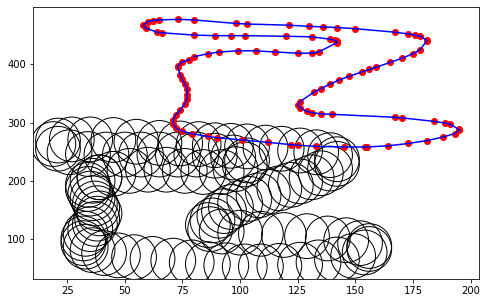

In [106]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_midpoints)
shortest_racing_line = opt_iterative_improvement(
    track_midpoints,
    compute_cost=length_and_angles,
    cost_func_params={"reg_param": 1, "init_cost": init_cost},
    spread=70,
    iterations=1000,
    debug=True,
    debug_iter=50,
    track_width=70,
)
draw_track_and_racing_line(track_midpoints, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

# Iterative Algorithm - 2

Started with: 527.3579423118641
Smallest hiterto: 0.281


C:\Users\priya\AppData\Local\Temp\ipykernel_23940\951336948.py:20: RuntimeWarning: invalid value encountered in true_divide
  vector2_unit = vector2 / np.linalg.norm(vector2)
C:\Users\priya\AppData\Local\Temp\ipykernel_23940\951336948.py:19: RuntimeWarning: invalid value encountered in true_divide
  vector1_unit = vector1 / np.linalg.norm(vector1)


Smallest hiterto: 0.281

Ended with: 523.363486552497

(523.363486552497, 0.1985903685810476)


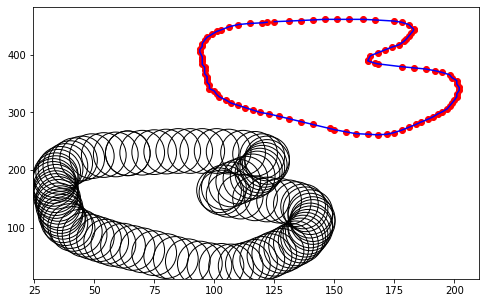

In [68]:
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(
    track_midpoints,
    compute_cost=length_and_angles,
    cost_func_params={"reg_param": 0.03, "init_cost": init_cost},
    spread=70,
    iterations=100,
    debug=True,
    debug_iter=50,
    track_width=70,
)
draw_track_and_racing_line(track_midpoints, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

(797.1669938050759, 0.2721886797274266)


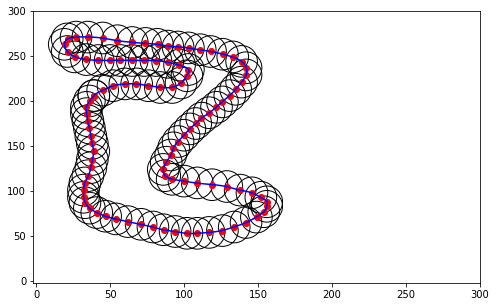

In [112]:
# Compute shortest racing line using the random-perturbation algorithm

shortest_racing_line, _ = opt_random_perturbation(
    result, spread=0.5, iterations=10000
)
draw_track_and_racing_line(
    result,
    shortest_racing_line,
    track_width=1,
    xlims=(-200, 600),
    ylims=(-200, 600),
    smooth=True,
)
print(_length_and_angles(shortest_racing_line))